# Classificação Iris

In [1]:
# PARÂMETROS
random_seed = 42
my_class = 'versicolor' # setosa, virginica, versicolor

# FEATURE SELECTION
center_stat = 'median'
select_by_center_stat = True
x_cols = ['petal_length', 'sepal_width']

# FOLDING
n_k_folds = 5

# MODEL SELECTION
n_std_lower_bound = 3
change_operation_point = True

# TREES
tree_criteria = 'entropy'
tree_hyperparameter = 'max_depth'
decision_tree_min_samples_leaf_range = range(15, 21)
decision_tree_max_depth = range(2, 5)

# RANDOM FOREST
n_estimators = range(2, 5)

# NEURAL NETWORK
optimizer = 'adam'
activation = 'tanh'
loss = 'mse'
metric = 'accuracy'
min_improvement = 0.001
batch_size = None
patience = 300
max_epochs = 10*patience
learning_rate = 0.005
n_hidden_layers_range = range(2, 6)
verbose = 0

# BOOLEANS FOR SELECTING MODELS
train_lr = True
train_lda = True
train_qda = True
train_tree = True
train_forest = True
train_nn = True

In [2]:
import keras
import numpy
import pandas
import seaborn
import tensorflow
from matplotlib import pyplot
from sklearn import datasets, tree
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

### PRÉ-PROCESSAMENTO

In [3]:
iris_dict = datasets.load_iris()
iris = pandas.DataFrame.from_dict(iris_dict['data'])
iris.columns = iris_dict['feature_names']
iris['species'] = iris_dict['target']
iris['species'] = iris['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris['y'] = (iris.species == my_class).astype(float)
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species,y
0,5.1,3.5,1.4,0.2,setosa,0.0
1,4.9,3.0,1.4,0.2,setosa,0.0
2,4.7,3.2,1.3,0.2,setosa,0.0
3,4.6,3.1,1.5,0.2,setosa,0.0
4,5.0,3.6,1.4,0.2,setosa,0.0
5,5.4,3.9,1.7,0.4,setosa,0.0
6,4.6,3.4,1.4,0.3,setosa,0.0
7,5.0,3.4,1.5,0.2,setosa,0.0
8,4.4,2.9,1.4,0.2,setosa,0.0
9,4.9,3.1,1.5,0.1,setosa,0.0


In [4]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width,y
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,0.333333
std,0.828066,0.435866,1.765298,0.762238,0.472984
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,0.000000
75%,6.400000,3.300000,5.100000,1.800000,1.000000
max,7.900000,4.400000,6.900000,2.500000,1.000000


### BALANÇO DE CLASSES

In [5]:
100.0*iris.y.value_counts(normalize=True)

y
0.0    66.666667
1.0    33.333333
Name: proportion, dtype: float64

### PairPlot

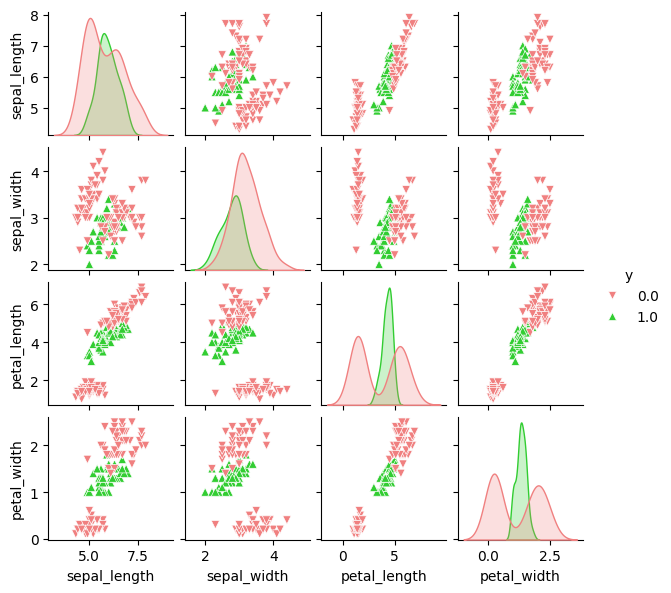

In [6]:
_ = seaborn.pairplot(iris, hue='y', height=1.5, palette={0: 'lightcoral', 1: 'limegreen'}, markers=['v', '^'])

### BOXPLOTS VARIAVEIS VS CLASSE

In [7]:
all_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
centers = iris.groupby(['y'])[all_cols].agg(center_stat).T
centers['diff'] = abs(centers[1] - centers[0])
centers = centers.sort_values('diff', ascending=False)

centers

y,0.0,1.0,diff
petal_length,3.2,4.35,1.15
sepal_width,3.2,2.80,0.40
petal_width,1.0,1.30,0.30
sepal_length,5.7,5.90,0.20


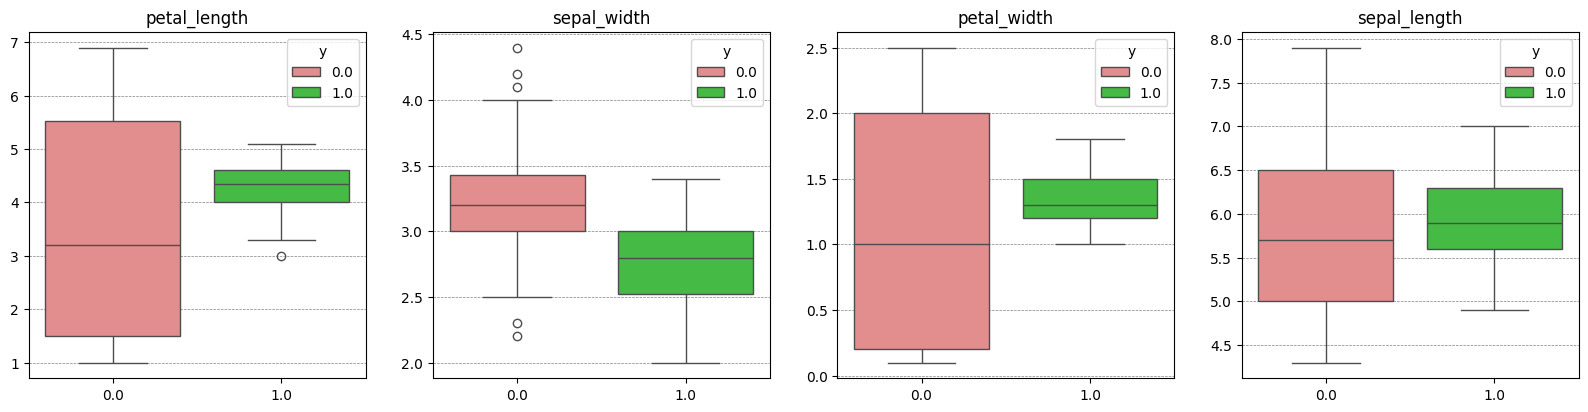

In [8]:
x_cols_sorted = centers['diff'].sort_values(ascending=False).index.tolist()

# BOXPLOT DOS ATRIBUTOS VS CLASSE
fig, axs = pyplot.subplots(1, 4, figsize=(20, 4.5))
for i, ax in enumerate(axs.flatten()):
    seaborn.boxplot(x='y', y=x_cols_sorted[i], data=iris, ax=ax, hue='y', dodge=False, palette=['lightcoral', 'limegreen'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(x_cols_sorted[i])
    ax.grid(which='both', axis='y', color='gray', linestyle='--', linewidth=0.5)

### Correlação



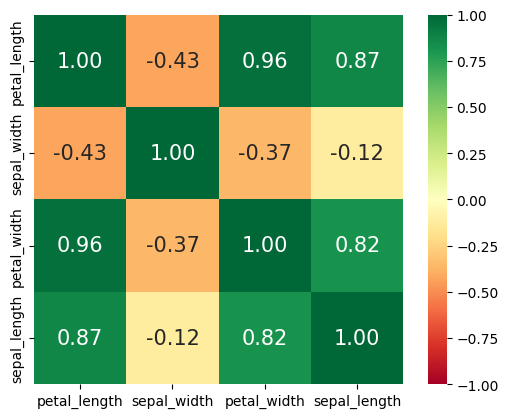

In [9]:
corr_matx = iris[x_cols_sorted].corr()
heatmap = seaborn.heatmap(corr_matx,
                          cbar=True,
                          annot=True,
                          square=True,
                          fmt='.2f',
                          annot_kws={'size': 15},
                          yticklabels=x_cols_sorted,
                          xticklabels=x_cols_sorted,
                          cmap='RdYlGn',
                          vmin=-1,
                          vmax=1)

### Classificador - Regressão Logística VS LDA


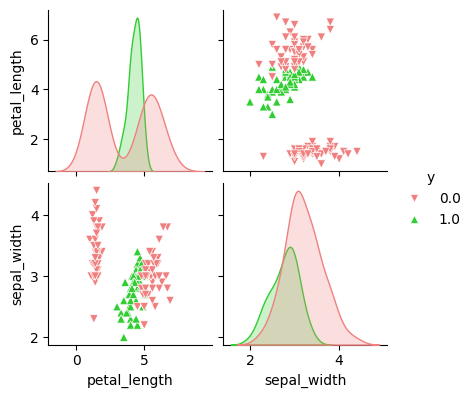

In [10]:
if select_by_center_stat:
    model_cols = x_cols_sorted[:2]
else:
    model_cols = x_cols

_ = seaborn.pairplot(iris[model_cols + ['y']], hue='y', height=2.0, palette={0: 'lightcoral', 1: 'limegreen'}, markers=['v', '^'])

In [11]:
# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)
skf = StratifiedKFold(n_splits=n_k_folds, shuffle=True, random_state=random_seed)

result_list = []
fold_ix = 0
for train_index, test_index in skf.split(iris[model_cols], iris['y']):
    X_train, X_test = iris[model_cols].iloc[train_index].to_numpy(), iris[model_cols].iloc[test_index].to_numpy()
    y_train, y_test = iris['y'].iloc[train_index].to_numpy(), iris['y'].iloc[test_index].to_numpy()

    # STANDARD SCALER
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # LDA
    if train_lda:
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train_scaled, y_train)
        y_pred_lda = lda.predict(X_test_scaled)
        lda_train_accuracy = 100.0*lda.score(X_train_scaled, y_train)
        lda_test_accuracy = 100.0*numpy.mean(y_pred_lda == y_test)
        result_list.append({'fold' : fold_ix, 'algorithm' : 'lda', 'hyperparameter' : 0, 'hyperconfig' : 'lda_0', 'model' : lda, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : lda_train_accuracy})
        result_list.append({'fold' : fold_ix, 'algorithm' : 'lda', 'hyperparameter' : 0, 'hyperconfig' : 'lda_0', 'model' : lda, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : lda_test_accuracy})
        print(f'Fold {fold_ix:02d} - LDA - Train: {lda_train_accuracy:.2f} - Test: {lda_test_accuracy:.2f}')

    # QDA
    if train_qda:
        qda = QuadraticDiscriminantAnalysis()
        qda.fit(X_train_scaled, y_train)
        y_pred_qda = qda.predict(X_test_scaled)
        qda_train_accuracy = 100.0*qda.score(X_train_scaled, y_train)
        qda_test_accuracy = 100.0*numpy.mean(y_pred_qda == y_test)
        result_list.append({'fold' : fold_ix, 'algorithm' : 'qda', 'hyperparameter' : 0, 'hyperconfig' : 'qda_0', 'model' : qda, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : qda_train_accuracy})
        result_list.append({'fold' : fold_ix, 'algorithm' : 'qda', 'hyperparameter' : 0, 'hyperconfig' : 'qda_0', 'model' : qda, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : qda_test_accuracy})
        print(f'Fold {fold_ix:02d} - QDA - Train: {qda_train_accuracy:.2f} - Test: {qda_test_accuracy:.2f}')

    # LOGISTIC REGRESSION
    if train_lr:
        lr = LogisticRegression(class_weight='balanced')
        lr.fit(X_train_scaled, y_train)
        y_pred = lr.predict(X_test_scaled)
        lr_train_accuracy = 100.0*lr.score(X_train_scaled, y_train)
        lr_test_accuracy = 100.0*numpy.mean(y_pred == y_test)
        result_list.append({'fold' : fold_ix, 'algorithm' : 'lr', 'hyperparameter' : 0, 'hyperconfig' : 'lr_0', 'model' : lr, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : lr_train_accuracy})
        result_list.append({'fold' : fold_ix, 'algorithm' : 'lr', 'hyperparameter' : 0, 'hyperconfig' : 'lr_0', 'model' : lr, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : lr_test_accuracy})
        print(f'Fold {fold_ix:02d} - LR - Train: {lr_train_accuracy:.2f} - Test: {lr_test_accuracy:.2f}')


    # TREES AND FORESTS
    if train_tree or train_forest:
        if tree_hyperparameter == 'max_depth':
            hyper_parameter_range = decision_tree_max_depth
        else:
            hyper_parameter_range = decision_tree_min_samples_leaf_range      
  
        if train_tree:
            for hyperparameter in hyper_parameter_range:
                if tree_hyperparameter == 'max_depth':
                    dt = tree.DecisionTreeClassifier(criterion=tree_criteria, max_depth=hyperparameter)
                elif tree_hyperparameter == 'min_samples_leaf':
                    dt = tree.DecisionTreeClassifier(criterion=tree_criteria, min_samples_leaf=hyperparameter) # class_weight='balanced'
                else:
                    raise ValueError('Invalid hyperparameter')
                dt.fit(X_train_scaled, y_train)
                y_pred = dt.predict(X_test_scaled)
                train_accuracy = 100.0*dt.score(X_train_scaled, y_train)
                test_accuracy = 100.0*numpy.mean(y_pred == y_test)
                result_list.append({'fold' : fold_ix, 'algorithm' : 'tree', 'hyperparameter' : hyperparameter, 'hyperconfig' : f'tree_{hyperparameter:02d}', 'model' : dt, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : train_accuracy})
                result_list.append({'fold' : fold_ix, 'algorithm' : 'tree', 'hyperparameter' : hyperparameter, 'hyperconfig' : f'tree_{hyperparameter:02d}', 'model' : dt, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : test_accuracy})
                print(f'Fold {fold_ix:02d} - DT - Hyperparameter: {hyperparameter:02d} - Train: {train_accuracy:.2f} - Test: {test_accuracy:.2f}')

        # RANDOM FOREST
        if train_forest:
            for hyperparameter in hyper_parameter_range:
                for n_estimator in n_estimators:
                    if tree_hyperparameter == 'max_depth':
                        rf = RandomForestClassifier(n_estimators=n_estimator, criterion=tree_criteria, max_depth=hyperparameter, random_state=random_seed)
                    elif tree_hyperparameter == 'min_samples_leaf':
                        rf = RandomForestClassifier(n_estimators=n_estimator, criterion=tree_criteria, min_samples_leaf=hyperparameter, random_state=random_seed)

                    rf.fit(X_train_scaled, y_train)
                    y_pred = rf.predict(X_test_scaled)
                    train_accuracy = 100.0*rf.score(X_train_scaled, y_train)
                    test_accuracy = 100.0*numpy.mean(y_pred == y_test)
                    result_list.append({'fold' : fold_ix, 'algorithm' : 'rf', 'hyperparameter' : n_estimator, 'hyperconfig' : f'rf_{n_estimator:02d}_{hyperparameter:02d}', 'model' : rf, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : train_accuracy})
                    result_list.append({'fold' : fold_ix, 'algorithm' : 'rf', 'hyperparameter' : n_estimator, 'hyperconfig' : f'rf_{n_estimator:02d}_{hyperparameter:02d}', 'model' : rf, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : test_accuracy})
                    print(f'Fold {fold_ix:02d} - RF - Hyperparameter: {n_estimator:02d}-{hyperparameter:02d} - Train: {train_accuracy:.2f} - Test: {test_accuracy:.2f}')

    # NEURAL NETWORK
    if train_nn:
        for n_hidden_layers in n_hidden_layers_range:
            # DECLARE NETWORK
            inputs = keras.layers.Input(shape=(X_train_scaled.shape[1],))
            hidden = keras.layers.Dense(n_hidden_layers, activation=activation)(inputs)
            outputs = keras.layers.Dense(1, activation='sigmoid')(hidden)
            model_name = f'nn_{n_hidden_layers:02d}'
            nn = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
            nn.compile(optimizer=optimizer, loss=loss, metrics=[metric])
            es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
            # es_metric = keras.callbacks.EarlyStopping(monitor=metric, mode='max', patience=patience, min_delta=min_improvement, restore_best_weights=True)
            es_val_metric = keras.callbacks.EarlyStopping(monitor=f'val_{metric}', mode='max', patience=2*patience, min_delta=min_improvement, restore_best_weights=True)

            # FIT W CLASS WEIGHTS
            my_class_weight = y_train.shape[0]/y_train.sum()
            other_class_weight = y_train.shape[0]/(y_train==0).sum()
            class_weights = {0: other_class_weight, 1: my_class_weight}
            history = nn.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=max_epochs, batch_size=batch_size, callbacks=[es_loss, es_val_metric], verbose=verbose, class_weight=class_weights)

            # UNPACK TRAINING RESULTS
            train_accuracy = 100.0*history.history['accuracy'][-1]
            test_accuracy = 100.0*history.history['val_accuracy'][-1]
            result_list.append({'fold' : fold_ix, 'algorithm' : 'nn', 'hyperparameter' : n_hidden_layers, 'hyperconfig' : f'nn_{n_hidden_layers:02d}', 'model' : nn, 'scaler' : scaler, 'stat' : 'train', 'accuracy' : train_accuracy})
            result_list.append({'fold' : fold_ix, 'algorithm' : 'nn', 'hyperparameter' : n_hidden_layers, 'hyperconfig' : f'nn_{n_hidden_layers:02d}', 'model' : nn, 'scaler' : scaler, 'stat' : 'test', 'accuracy' : test_accuracy})
            print(f'Fold {fold_ix:02d} - NN - Hyperparameter: {n_hidden_layers:02d} - Train: {train_accuracy:.2f} - Test: {test_accuracy:.2f} - Epochs {len(history.epoch)}')

    fold_ix += 1

Fold 00 - LDA - Train: 71.67 - Test: 76.67
Fold 00 - QDA - Train: 93.33 - Test: 93.33
Fold 00 - LR - Train: 68.33 - Test: 66.67
Fold 00 - DT - Hyperparameter: 02 - Train: 95.83 - Test: 93.33
Fold 00 - DT - Hyperparameter: 03 - Train: 95.83 - Test: 93.33
Fold 00 - DT - Hyperparameter: 04 - Train: 95.83 - Test: 93.33
Fold 00 - RF - Hyperparameter: 02-02 - Train: 95.83 - Test: 93.33
Fold 00 - RF - Hyperparameter: 03-02 - Train: 88.33 - Test: 83.33
Fold 00 - RF - Hyperparameter: 04-02 - Train: 94.17 - Test: 96.67
Fold 00 - RF - Hyperparameter: 02-03 - Train: 92.50 - Test: 96.67
Fold 00 - RF - Hyperparameter: 03-03 - Train: 92.50 - Test: 90.00
Fold 00 - RF - Hyperparameter: 04-03 - Train: 94.17 - Test: 96.67
Fold 00 - RF - Hyperparameter: 02-04 - Train: 92.50 - Test: 96.67
Fold 00 - RF - Hyperparameter: 03-04 - Train: 92.50 - Test: 93.33
Fold 00 - RF - Hyperparameter: 04-04 - Train: 95.00 - Test: 96.67
Fold 00 - NN - Hyperparameter: 02 - Train: 94.17 - Test: 96.67 - Epochs 1391
Fold 00 - NN

In [12]:
df_results = pandas.DataFrame(result_list).sort_values(['accuracy', 'stat'], ascending=[False, True])

df_results

,fold,algorithm,hyperparameter,hyperconfig,model,scaler,stat,accuracy
155,4,qda,0,qda_0,QuadraticDiscriminantAnalysis(),StandardScaler(),test,100.000000
159,4,tree,2,tree_02,"DecisionTreeClassifier(criterion='entropy', ma...",StandardScaler(),test,100.000000
161,4,tree,3,tree_03,"DecisionTreeClassifier(criterion='entropy', ma...",StandardScaler(),test,100.000000
165,4,rf,2,rf_02_02,"(DecisionTreeClassifier(criterion='entropy', m...",StandardScaler(),test,100.000000
167,4,rf,3,rf_03_02,"(DecisionTreeClassifier(criterion='entropy', m...",StandardScaler(),test,100.000000
...,...,...,...,...,...,...,...,...
5,0,lr,0,lr_0,LogisticRegression(class_weight='balanced'),StandardScaler(),test,66.666667
39,1,lda,0,lda_0,LinearDiscriminantAnalysis(),StandardScaler(),test,66.666667
81,2,lr,0,lr_0,LogisticRegression(class_weight='balanced'),StandardScaler(),test,66.666667
156,4,lr,0,lr_0,LogisticRegression(class_weight='balanced'),StandardScaler(),train,65.000000


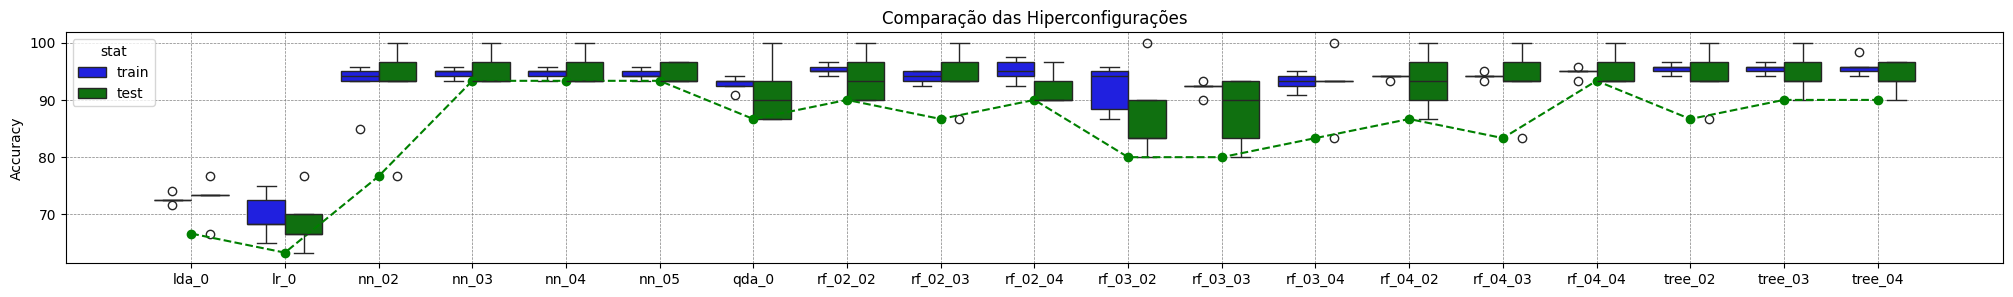

In [13]:
# BOXPLOT LDA VS LR FOR TRAIN AND TEST ACCURACY
hyperconfigs = df_results.hyperconfig.sort_values().unique()
min_accuracies = df_results.groupby('hyperconfig')['accuracy'].agg('min')
fig = pyplot.figure(figsize=(25, 3))
ax = fig.add_subplot(111)
_ = seaborn.boxplot(x='hyperconfig', y='accuracy', data=df_results, hue='stat', palette=['blue', 'green'], order=hyperconfigs, ax=ax, hue_order=['train', 'test'])
ax.plot(hyperconfigs, min_accuracies, ls='--', marker='o', color='green', label='min accuracy')
ax.set_title('Comparação das Hiperconfigurações')
ax.set_ylabel('Accuracy')
ax.set_xlabel('')
ax.grid(which='both', color='gray', linestyle='--', linewidth=0.5)

In [14]:
# PICK THE BEST MODEL BY THE LOWER BOUND OF THE TEST ACCURACY
df_grouped = df_results.groupby(['hyperconfig', 'stat']).agg({'accuracy' : ['mean', 'std']}).reset_index()
df_grouped.columns = ['hyperconfig', 'stat', 'mean_accuracy', 'std_accuracy']
df_grouped['lower_bound'] = df_grouped['mean_accuracy'] - n_std_lower_bound*df_grouped['std_accuracy']
df_grouped = df_grouped.sort_values(['lower_bound', 'hyperconfig'], ascending=[False, True])

df_grouped

,hyperconfig,stat,mean_accuracy,std_accuracy,lower_bound
27,rf_04_02,train,94.000000,0.372678,92.881966
33,tree_02,train,95.500000,0.950146,92.649561
35,tree_03,train,95.500000,0.950146,92.649561
15,rf_02_02,train,95.333333,0.950146,92.482895
29,rf_04_03,train,94.166667,0.589256,92.398900
31,rf_04_04,train,94.833333,0.912871,92.094721
7,nn_03,train,94.666666,0.950145,91.816230
9,nn_04,train,94.666666,0.950145,91.816230
11,nn_05,train,94.499999,0.950145,91.649563
37,tree_04,train,95.833333,1.559024,91.156262


In [15]:
is_test = df_grouped['stat'] == 'test'
best_hyperconfig = df_grouped.loc[is_test, 'hyperconfig'].values[0]
best_hyperconfig_stats = df_grouped.loc[is_test & (df_grouped['hyperconfig'] == best_hyperconfig), ['mean_accuracy', 'std_accuracy', 'lower_bound']].values[0]

print(f'Melhor HyperConfig foi {best_hyperconfig} com média de acurácia de {best_hyperconfig_stats[0]:.2f} +/- {best_hyperconfig_stats[1]:.2f} e limite inferior de {best_hyperconfig_stats[2]:.2f}')

Melhor HyperConfig foi nn_05 com média de acurácia de 94.67 +/- 1.83 e limite inferior de 89.19


### RE-TREINO DO MELHOR MODELO

In [16]:
# PICK THE BEST MODEL
is_best_model = (df_results['hyperconfig'] == best_hyperconfig) & (df_results['stat'] == 'test')
best_algorithm = df_results.loc[is_best_model, 'algorithm'].values[0]
best_scaler = df_results.loc[is_best_model, 'scaler'].values[0]
best_model = df_results.loc[is_best_model, 'model'].values[0]

print(f'Melhor modelo foi {best_model}')

Melhor modelo foi <Functional name=nn_05, built=True>


In [17]:
# RETRAIN BEST MODEL
X = iris[model_cols].to_numpy()
y = iris['y'].to_numpy()
X_scaled = best_scaler.fit_transform(X)
best_model.fit(X_scaled, y)
if best_algorithm == 'nn':
    y_pred = best_model.predict(X_scaled, verbose=0).flatten()
else:
    best_model.fit(X_scaled, y)
    y_pred = best_model.predict(X_scaled)

best_accuracy = 100.0*numpy.mean((y_pred > 0.5).astype(int) == y)

print(f'Acurácia do melhor modelo foi {best_accuracy:.2f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9361 - loss: 0.0730  
Acurácia do melhor modelo foi 92.67


### VISUALIZAR SEPARADOR, MATRIZ DE CONFUSÃO E ROC

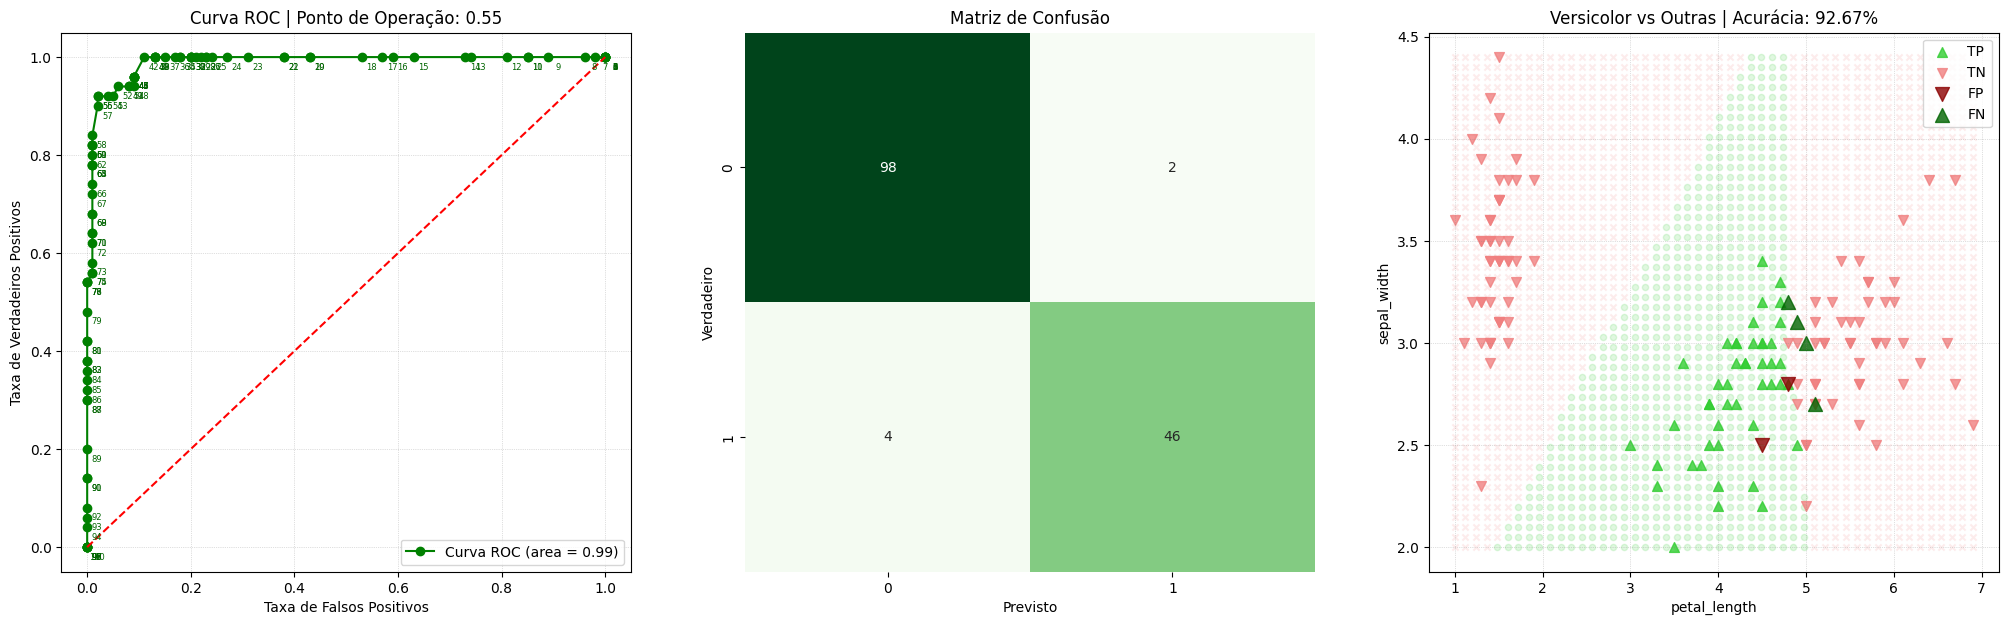

In [18]:
x_col = model_cols[0]
y_col = model_cols[1]

linspace_points = 50
roc_thresholds = 100

# PLOT ROC
if best_algorithm == 'nn':
    y_pred_proba = best_model.predict(X_scaled, verbose=0).flatten()
else:
    y_pred_proba = best_model.predict_proba(X_scaled)[:,1]    

proba_linspace = numpy.linspace(0, 1, roc_thresholds)

roc_points = []
for i, threshold in enumerate(proba_linspace):
    y_pred = (y_pred_proba > threshold).astype(float)
    tp = numpy.sum((y == 1) & (y_pred == 1))
    tn = numpy.sum((y == 0) & (y_pred == 0))
    fp = numpy.sum((y == 0) & (y_pred == 1))
    fn = numpy.sum((y == 1) & (y_pred == 0))
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    roc_points.append((threshold, fpr, tpr))

if change_operation_point:
    best_operation_point = max(roc_points, key=lambda x: x[2] - x[1])
else:
    best_operation_point = (0.5, 0.5, 0.5)
    
y_pred_operation = (y_pred_proba > best_operation_point[0]).astype(float)

fig = pyplot.figure(figsize=(25, 7))
# PLOT AND ANNOTATE ROC CURVE
ax = fig.add_subplot(131)
_ = ax.plot([x[1] for x in roc_points], [x[2] for x in roc_points], color='green', label=f'Curva ROC (area = {roc_auc_score(y, y_pred_proba):.2f})', marker='o')
_ = ax.plot([0, 1], [0, 1], color='red', linestyle='--')
_ = ax.set_xlabel('Taxa de Falsos Positivos')
_ = ax.set_ylabel('Taxa de Verdadeiros Positivos')
_ = ax.set_title(f'Curva ROC | Ponto de Operação: {best_operation_point[0]:.2f}')
_ = ax.legend()
_ = ax.grid(which='both', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
# ANNOTATE ROC CURVE
for i, threshold in enumerate(proba_linspace):
    ax.annotate(f'{100.0*threshold:.0f}', (roc_points[i][1], roc_points[i][2]), textcoords='offset points', xytext=(7, -7), ha='center', va='center', fontsize=6, color='darkgreen')

# PLOT CONFUSION MATRIX
conf_matrix = confusion_matrix(y, y_pred_operation)

ax = fig.add_subplot(132)
_ = seaborn.heatmap(conf_matrix, annot=True, cmap='Greens', cbar=False, ax=ax)
_ = ax.set_xlabel('Previsto')
_ = ax.set_ylabel('Verdadeiro')
_ = ax.set_title('Matriz de Confusão')

class_areas_list = []
linspace_point_list = []
for x_i in numpy.linspace(iris[x_col].min(),iris[x_col].max(), linspace_points):
    for y_i in numpy.linspace(iris[y_col].min(),iris[y_col].max(), linspace_points):
        if best_algorithm == 'nn':
            p_i = best_model.predict(best_scaler.transform([[x_i, y_i]]), verbose=0).flatten()[0]
        else:
            p_i = best_model.predict_proba(best_scaler.transform([[x_i, y_i]]))[0][1]

        if p_i > best_operation_point[0]:
            c_i = 1
        else:
            c_i = 0

        class_areas_list.append({'x': x_i, 'y': y_i, 'c': c_i, 'p': p_i})

class_areas_df = pandas.DataFrame(class_areas_list)
ax = fig.add_subplot(133)
_ = class_areas_df[class_areas_df['c'] == 0].plot.scatter(x='x', y='y', color='lightcoral', ax=ax, alpha=0.15, marker='x')
_ = class_areas_df[class_areas_df['c'] == 1].plot.scatter(x='x', y='y', color='limegreen', ax=ax, alpha=0.15, marker='o')

# PLOT TRUE POSITIVES
_ = iris[(iris['y'] == 1.0) & (y_pred_operation == 1.0)].plot.scatter(x=x_col,y=y_col, color='limegreen', label='TP', ax=ax, s=50, alpha=0.8, marker='^')
# PLOT TRUE NEGATIVES
_ = iris[(iris['y'] == 0.0) & (y_pred_operation == 0.0)].plot.scatter(x=x_col,y=y_col, color='lightcoral', label='TN', ax=ax, s=50, marker='v', alpha=0.8)
# PLOT FALSE POSITIVES
_ = iris[(iris['y'] == 0.0) & (y_pred_operation == 1.0)].plot.scatter(x=x_col,y=y_col, color='darkred', label='FP', ax=ax, s=100, alpha=0.8, marker='v')
# PLOT FALSE NEGATIVES
_ = iris[(iris['y'] == 1.0) & (y_pred_operation == 0.0)].plot.scatter(x=x_col,y=y_col, color='darkgreen', label='FN', ax=ax, s=100, alpha=0.8, marker='^')
_ = ax.set_title(f"{my_class.capitalize()} vs Outras | Acurácia: {best_accuracy:.2f}%")
_ = ax.grid(which='both', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

### RE-TREINAR E PLOTAR A MELHOR ÁRVORE

In [19]:
is_best_tree_hyperconfig = df_grouped.hyperconfig.str.contains('tree') & (df_grouped['stat'] == 'test')
best_tree_hyperconfig = df_grouped.loc[is_best_tree_hyperconfig, 'hyperconfig'].values[0]

best_tree_hyperconfig

'tree_04'

In [20]:
is_best_tree = (df_results['hyperconfig'] == best_tree_hyperconfig) & (df_results['stat'] == 'test')
best_tree_model = df_results.loc[is_best_tree, 'model'].values[0]

print(f'Melhor modelo de árvore foi {best_tree_model}')

Melhor modelo de árvore foi DecisionTreeClassifier(criterion='entropy', max_depth=4)


In [21]:
best_tree_model.fit(X, y)

y_tree_pred = best_tree_model.predict(X)

y_tree_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

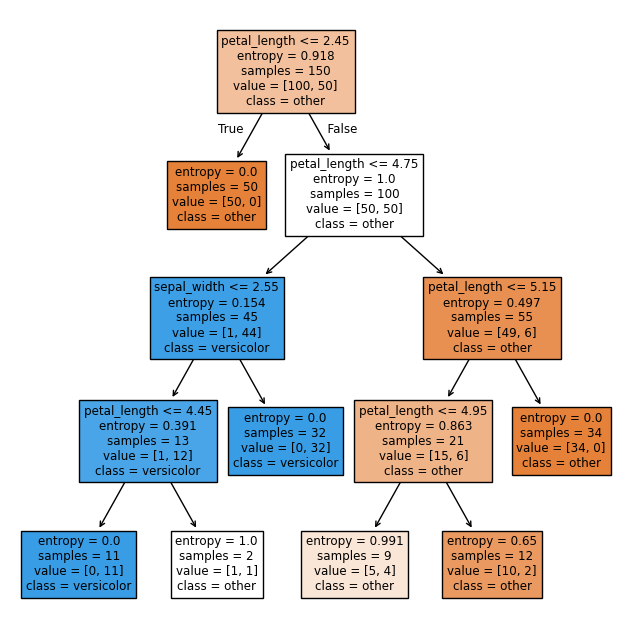

In [22]:


fig = pyplot.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
_ = tree.plot_tree(best_tree_model, feature_names=model_cols, class_names=['other', my_class], filled=True, ax=ax)

In [23]:
is_best_random_forest_hyperconfig = df_grouped.hyperconfig.str.contains('rf') & (df_grouped['stat'] == 'test')
best_random_forest_hyperconfig = df_grouped.loc[is_best_random_forest_hyperconfig, 'hyperconfig'].values[0]

best_random_forest_hyperconfig

'rf_04_04'

In [24]:
is_best_random_forest = (df_results['hyperconfig'] == best_random_forest_hyperconfig) & (df_results['stat'] == 'test')
best_random_forest_model = df_results.loc[is_best_random_forest, 'model'].values[0]

print(f'Melhor modelo de random forest foi {best_random_forest_model}')

Melhor modelo de random forest foi RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=4,
                       random_state=42)


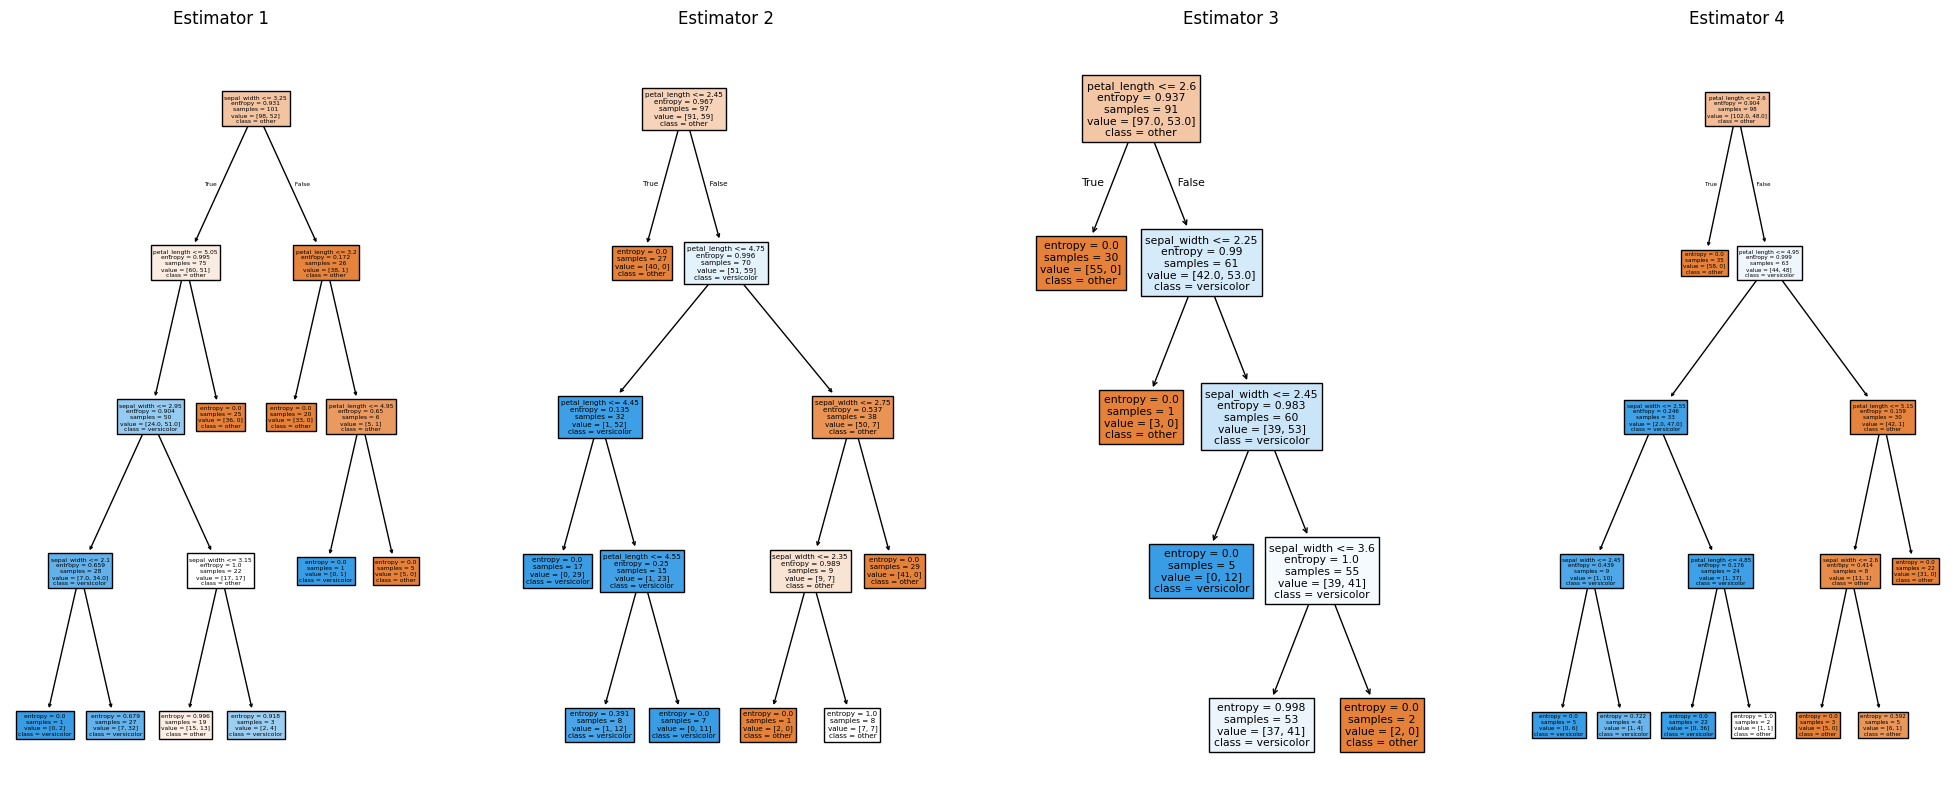

In [25]:
best_random_forest_model.fit(X, y)

# PLOT ALL ESTIMATORS
fig = pyplot.figure(figsize=(25, 10))
for i, tree_in_forest in enumerate(best_random_forest_model.estimators_):
    ax = fig.add_subplot(1, len(best_random_forest_model.estimators_), i+1)
    _ = tree.plot_tree(tree_in_forest, feature_names=model_cols, class_names=['other', my_class], filled=True, ax=ax)
    ax.set_title(f'Estimator {i+1}')